In [101]:
import requests, bs4, urllib3, re, time
import numpy as np
from semantic.numbers import NumberService
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

#import seaborn as sns
%matplotlib inline


vocation = 'data_scientist'
location= ''
service = NumberService()
links=[]
years_experience=[]

In [102]:
links=[]
location=[]
title=[]
company=[]

sess = requests.Session()
adapter = requests.adapters.HTTPAdapter(max_retries = 20)
sess.mount('http://', adapter)
'''
this portion scrapes indeed.com and builds an array with the location, title, and company for each posting
'''

for j in range(0,500,10):
    print 'getting page ' + str(j/10)
    response1 = sess.get('https://www.indeed.com/jobs?q='+str(vocation)+'&start='+str(j));
    #response1 = sess.get('https://www.indeed.com/jobs?q='+str(vocation)+'&l='+str(location)+'&start='+str(j));
    #previous line is if you want to add a location
    soup=bs4.BeautifulSoup(response1.text, "lxml")
    for i in range(10):
        try:
            initial=str(soup.find_all('span', attrs={'itemprop':'addressLocality'})[i].get_text())#gets location from indeed
            location.append(initial[0:initial.index(',')+4])
            title.append(str(soup.find_all('a', attrs={'itemprop':'title'})[i].get_text().encode('utf-8'))) #gets job title from indeed
            company.append(str(soup.find_all('span', attrs={'itemprop':'name'})[i].getText().strip()))
        except:
            pass
            print "page "+str(j/10)+" failed"
        clear_output()
        
    for link in soup.find_all('a', attrs={'itemprop':'title'}): # href=re.compile('rc/clk')
        links.append(link['href'])
      

In [103]:
'''
this portion retrieves latitude and longitude for all the locations. 
Super clunky and slow and could be optimized, but aint nobody got time for that
'''
from geopy.geocoders import Nominatim
geolocator = Nominatim()
lat=[]
longi=[]
for i in range(len(location)):
    try:
        geos=geolocator.geocode(location[i])
        lat.append(geos.latitude)
        longi.append(geos.longitude)
        print str(i+1)+' successes so far'
    except:
        pass
        print 'bummer'+str(i)
    time.sleep(0.5)
    clear_output()


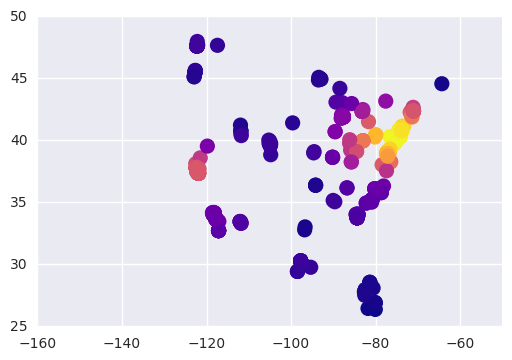

In [104]:
from scipy.stats import gaussian_kde
'''
smooths the latitude and longitude with a gaussian kernel that makes a heat map
'''

xy = np.vstack([longi,lat])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(longi, lat, c=z, s=120,cmap = plt.cm.plasma, edgecolor='')
plt.xlim(-160,-50)
plt.show()

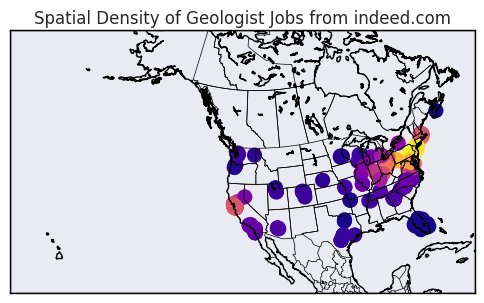

In [105]:
from mpl_toolkits.basemap import Basemap
from scipy.stats import gaussian_kde
'''
same as above, but it adds in a basemap, you can change extents with the llcrnlon items llcrn means lower left corner longitude
'''
x=longi
y=lat
xy = np.vstack([longi,lat])

z=gaussian_kde(xy)(xy)
max_color_by = max(z)
min_color_by = min(z)
m = Basemap(projection='lcc',lat_1=45.,lat_0=50,lon_0=-117.,llcrnrlon=-160,llcrnrlat=10,urcrnrlon=-40,urcrnrlat=50,resolution='l')

x1,y1=m(x,y)

m.drawcoastlines()

m.drawmapboundary(fill_color='black') # fill to edge
m.drawcountries()

m.fillcontinents(color='white',lake_color='black',zorder=0)
m.drawmapboundary()

m.drawstates()

m.scatter(x1,y1,s=120, c=z, cmap = plt.cm.plasma, vmin = min_color_by,vmax = max_color_by, edgecolor='')
#plt.colorbar()
plt.title("Spatial Density of Geologist Jobs from indeed.com")
plt.rcParams["figure.figsize"] = [10,10]

plt.show()

In [106]:
city=[]
state=[]
for i in range(len(location)):
    city.append(location[i][0:location[i].index(',')])
    state.append(location[i][location[i].index(',')+2:])

    

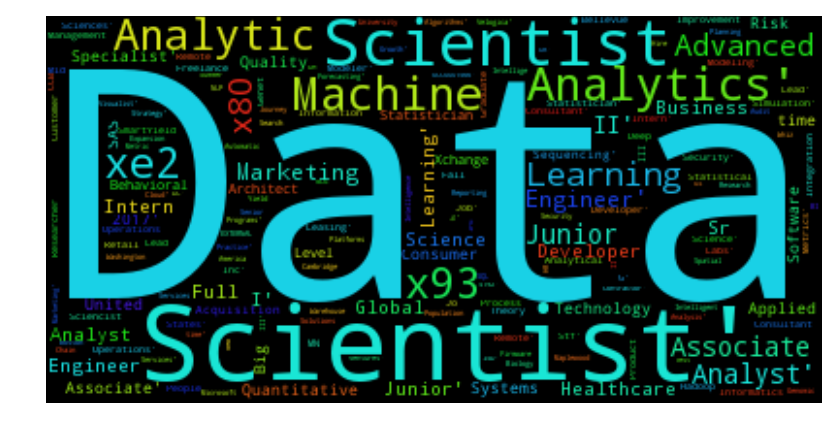

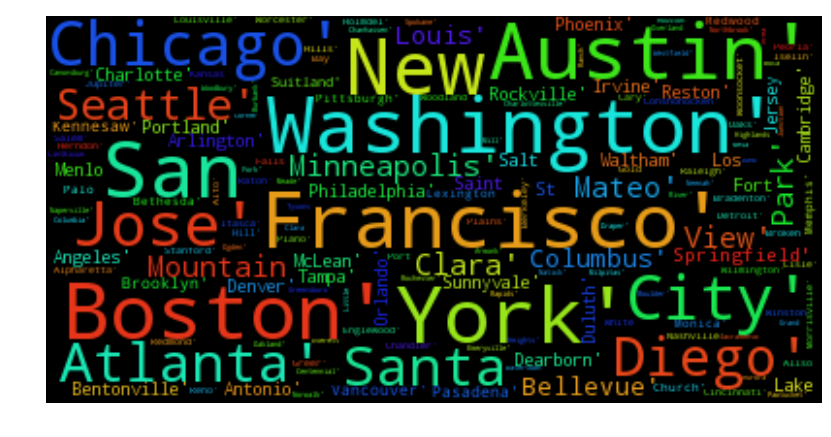

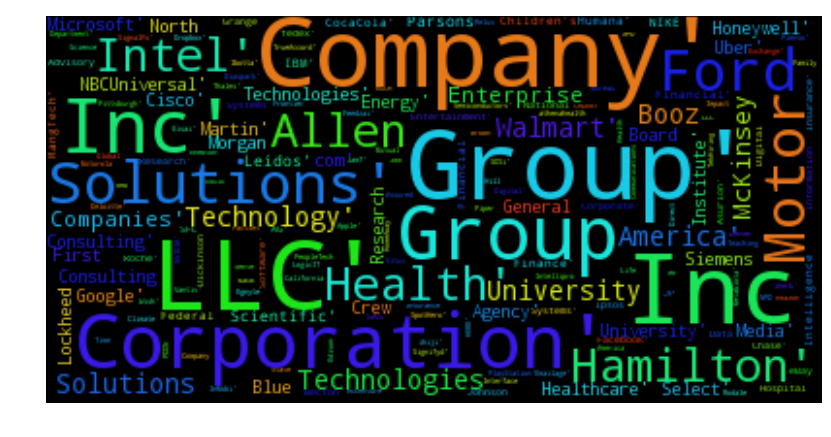

In [107]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(str(title))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# lower max_font_size max_font_size=40
wordcloud = WordCloud(max_font_size=40).generate(str(city))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

wordcloud = WordCloud(max_font_size=50).generate(str(company))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

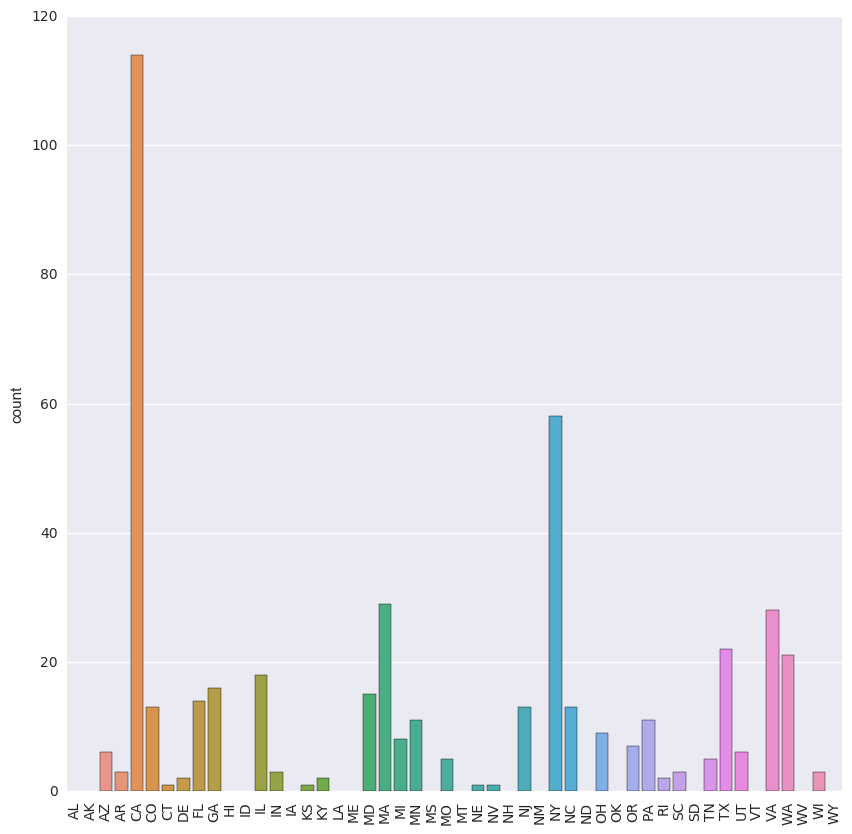

In [108]:
import seaborn as sns
sns.countplot(state, order=['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'])
plt.xticks(rotation=90)


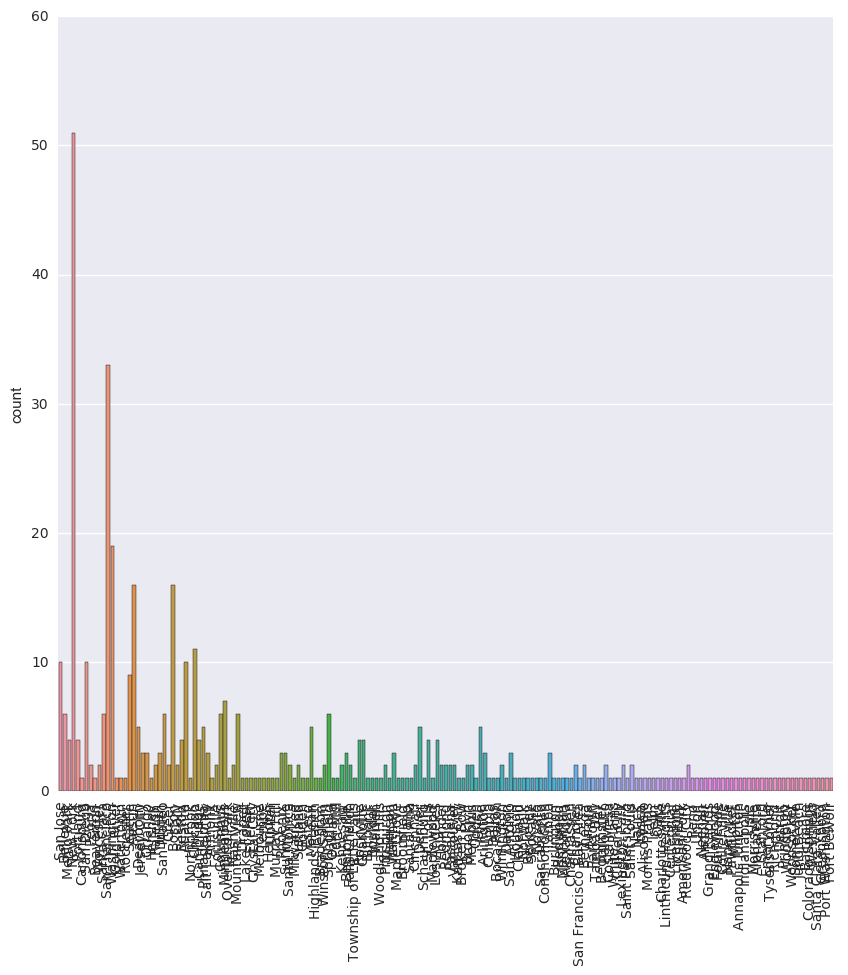

In [109]:
'''
this is a nightmare when broken down by city
'''
sns.countplot(city)
plt.xticks(rotation=90)
plt.legend()

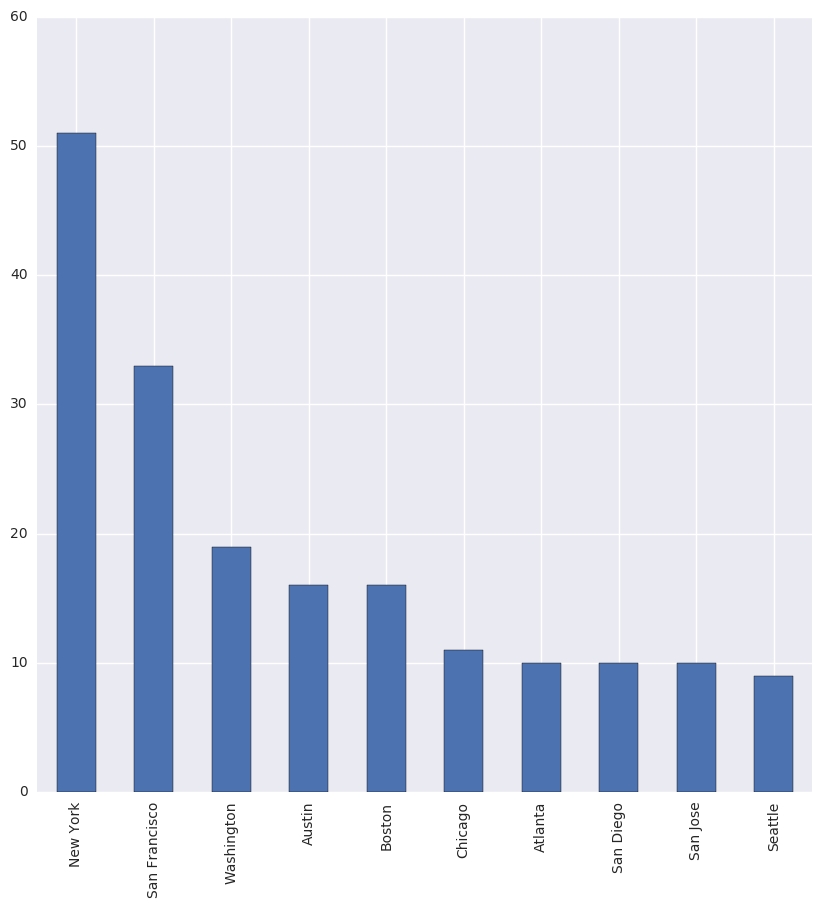

In [110]:
'''
lets just take the top 10 cities with the most postings
'''
cityDF=pd.DataFrame({'city':city})
cityDF['city'].value_counts()[:10].plot.bar()
                             



In [119]:
'''
another scrape, this one actually opens all the job postings and extracts the section of text with the word 'year'
then looks for a number in some format to gather how many years experience the company is looking for in the posting
'''
years_experience=[]
sess = requests.Session()
adapter = requests.adapters.HTTPAdapter(max_retries = 20)
sess.mount('http://', adapter)
for i in range(0,500,10):
    for j in range(i,i+10):
        try:
            deets=sess.get('http://www.indeed.com/'+links[j]);
            tried=bs4.BeautifulSoup(deets.text, 'lxml');
            t2=tried.get_text();
            try:
                years_experience.append(t2[t2.index('years')-7:t2.index('years')])
            except:
                years_experience.append(np.nan)
        except:
            pass
    

In [120]:
'''
parse the years into integers
'''
for i in range(len(years_experience)):
    try:
        years_experience[i]=service.parse(str(years_experience[i]).strip())
        
    except:
        try:
            years_experience[i]=int(int(filter(str.isdigit, str(years_experience[i]).strip().replace('-', '0')))%25)
        except:
            years_experience[i]=(np.nan)

In [121]:
'''
creates a dataframe from the parsed years experience integers
'''
df=pd.DataFrame({'years experience':years_experience})
df.head()


,years experience
0,NaN
1,2.0
2,NaN
3,2.0
4,NaN


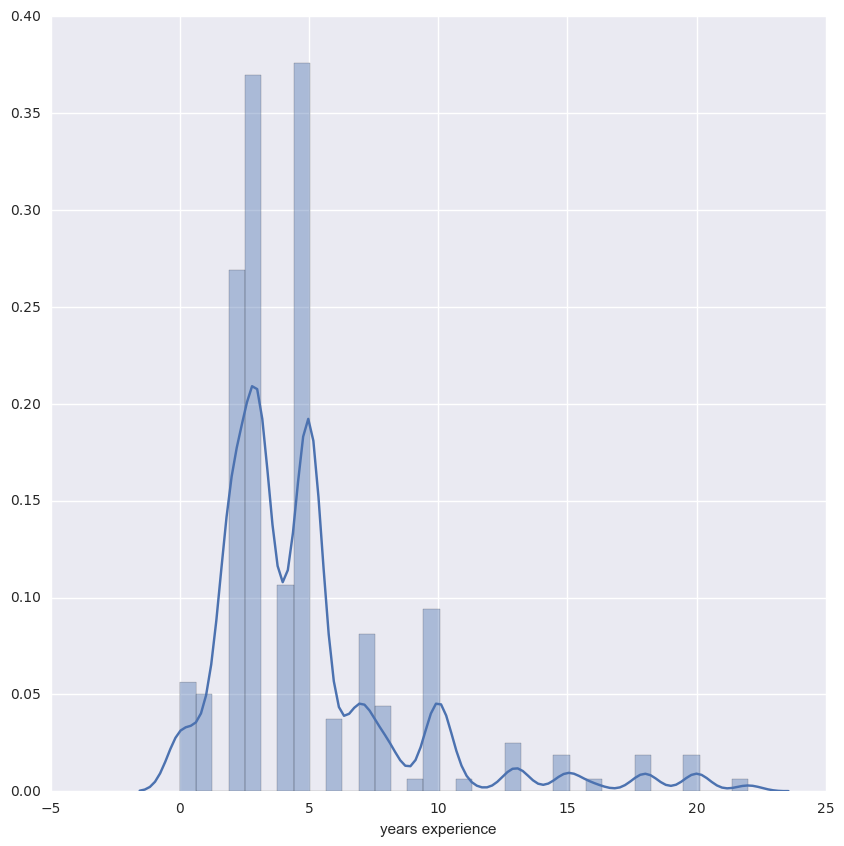

In [122]:
import seaborn as sns
sns.distplot(df['years experience'].dropna())